# **Module 3 : Preprocessing des données avec l'API tf.data**

Pourquoi s'interesser aux pipelines ?

- Les modèles de DL ont besoins de beaucoup de données
- Avant que la donnée ne soit envoyée au modèle, idéalement elle devrait :
  - être mélangée
  - mise en minibatch
  - les minibatchs devraient être disponibles avant la fin de l'époque précédente.

![](./images/cpu_gpu_idle.svg)

## **Import des librairies**

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

import os
import numpy as np
import random

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

2.2.0-rc3
2.3.0-tf


In [2]:
!nvidia-smi

Wed Apr 29 11:34:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from sklearn.model_selection import train_test_split

from os import listdir
from os.path import isfile, join
import shutil
import time

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import optimizers

In [0]:
from tensorflow.keras.applications import VGG16

def vgg_model(input_size, num_classes, lr=0.001, freezed=True):

  conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(input_size, input_size, 3))

  #conv_base.summary()

  if freezed:
      conv_base.trainable = False
      #for layer in conv_base.layers:
        #print(f'{layer.name}, Trainable : {layer.trainable}')

  model = models.Sequential([
      conv_base,
      Flatten(),
      Dense(256, activation='relu'),
      Dense(128,activation='relu'),
      Dense(num_classes, activation='softmax')
  ])

  model.compile(loss = 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.SGD(lr=lr),
                metrics=['accuracy'])  

  return model

## **La version classique, ImageDataGenerator**


Lors du dernière, on a vu que les couches convolutives étaient invariantes par translation, en d'autres termes que la position de l'objet que le CNN doit détecter dans l'image n'est pas importante. Au contraire des couches de neurones denses.

Cependant, les couches convolutives ne sont pas invariantes par les autres transformations géométriques : rotation, dilatation, symétrie, modification du contraste, etc.

Pour rendre un CNN robuste à ces modifications, on applique alors ce que l'on appelle de l'augmentation.

`ImageDataGenerator` est la méthode de base lorsque que l'on souhaite créer un dataset d'images avec une série d'augmentations.

Ici, avec la commande suivante

```python
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    #brightness_range=(0.1, 0.9),
    shear_range=15
    )
```

**on définit un générateur** pour le jeu d'entraînement, qui sera appliqué à chaque minibatch.

Le principe est le suivant :

1. On sélectionne un minibatch
2. Ce minibatch est alors est alors envoyé dans `train_datagen`, où les opérations listées seront appliquées, soit de façon certaine comme le `rescale`, soit avec une certaine probabilité.
3. Ce minibatch augmenté est alors donné pour entraînement au modèle.

Il faut comprendre la chose suivante :

**L'augmentation des données se fait à la volée, l'intégrité des données stockées sur votre DD n'est jamais remise en cause**.

Appliquons maintenant la librairie `ImageDataGenerator`

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# set up image augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    #brightness_range=(0.1, 0.9),
    shear_range=15
    )

test_datagen = ImageDataGenerator(rescale=1/255)

### **Exemple**

Prenons le dataset CIFAR10, et voyons un peu ce que font les différentes transformations.

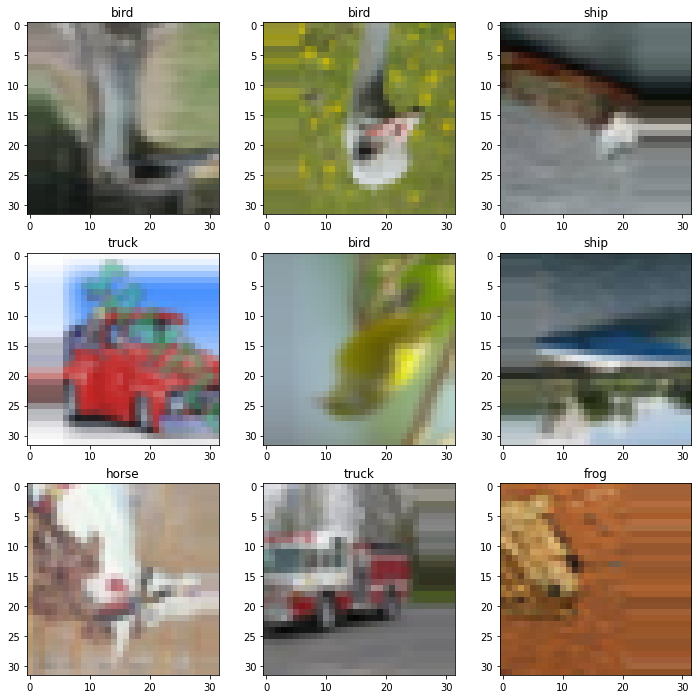

In [111]:
# load data
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.cifar10.load_data()

X_train = X_train.reshape(-1, 32, 32, 3).astype('float32')
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32')

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# define data preparation, mettez les transformations de la cellules précédentes que vous souhaitez observer.
datagen = ImageDataGenerator(rescale=1/255,
                             width_shift_range=0.3,
                             horizontal_flip=True,
                             vertical_flip=True)
# fit parameters from data
datagen.fit(X_train)

n_rows = 3
n_cols = 3
plt.figure(figsize=(n_cols * 4, n_rows * 4))

# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
  for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(32, 32, 3))
    plt.title(class_names[int(y_batch[i])])

  plt.show()
  break

## **Augmentation sur des données stockées en local**

Souvent, les données ne sont pas stockées sous la forme de fichiers plats, mais déjà répertorié dans des dossiers. Dans ce cas là c'est la méthode `flow_from_directory` qui nous permettra de mettre en place le générateur d'augmentations.

In [0]:
# Get the flowers' dataset
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [10]:
!ls {flowers}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [0]:
class_names=['daisy', 'dandelion', 'roses',  'sunflowers',  'tulips']

In [0]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range=45)

In [27]:
# Verify the shapes yielded by the data generator
train_gen = train_datagen.flow_from_directory(flowers,
                                              class_mode="categorical",
                                              target_size=(224, 224),
                                              batch_size=1,
                                              color_mode="rgb",
                                              shuffle=True,
                                              seed=RANDOM_SEED)

for data_batch, labels_batch in train_gen:
  print(f'data batch shape : {data_batch.shape}')
  print(f'{labels_batch}, labels batch shape : {labels_batch.shape}')
  break

Found 3670 images belonging to 5 classes.
data batch shape : (1, 224, 224, 3)
[[1. 0. 0. 0. 0.]], labels batch shape : (1, 5)


Pour voir les modifications apportées, on crée des minibatchs de taille 1, et on en sélectionne par exemple 9.

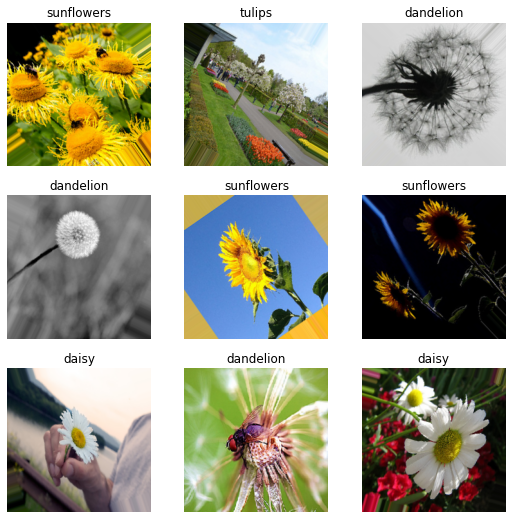

In [28]:
# create a grid of 3x3 images
plt.figure(figsize=(9, 9))
for i in range(0, 9):
  X_batch, y_batch  = next(train_gen)
  plt.subplot(330 + 1 + i)
  plt.imshow(X_batch[0, :, :, :])
  plt.axis('off')
  plt.title(class_names[np.argmax(y_batch[0])], fontsize=12)
# show the plot
plt.show()


Dans le cas où l'on a un dossier d'entraînement, un de validation et un de test. Il faut 3 flows différents.

```python
test_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True)

test_gen = test_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

val_gen = test_datagen.flow_from_directory(validation_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')
```

In [29]:
vgg_tf= vgg_model(input_size = 224,
                  num_classes= 5)

vgg_tf.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 21,171,013
Trainable params: 6,456,325
Non-trainable params: 14,714,688
_________________________________________________________________


Dans le cas où les données sont sotckées sous la forme de fichiers plats, Tensorflow sait le nombre d'étapes par époques à effectuer. Avec un générateur possiblement infini, il faut lui préciser.

In [0]:
from imutils import paths
total_data = len(list(paths.list_images(flowers)))
total_data
total_steps = total_data//32

In [31]:
start = time.time()
history = vgg_tf.fit(
    train_gen,
    steps_per_epoch = total_steps,
    epochs=5)
print(f"It took {time.time() - start} seconds")

Epoch 1/5
114/114 [==============================] - 2s 19ms/step - loss: 1.7583 - accuracy: 0.3158
Epoch 2/5
114/114 [==============================] - 2s 19ms/step - loss: 1.6554 - accuracy: 0.2632
Epoch 3/5
114/114 [==============================] - 2s 20ms/step - loss: 1.6346 - accuracy: 0.2193
Epoch 4/5
114/114 [==============================] - 2s 19ms/step - loss: 1.4662 - accuracy: 0.3596
Epoch 5/5
114/114 [==============================] - 2s 20ms/step - loss: 1.3950 - accuracy: 0.3772
It took 18.20056986808777 seconds


On est capable de faire de l'augmentation, seul problème, on a besoin de définir le nombre d'étapes à chaque époque pour l'entraînement et la validation. 

### Combinaison avec tf.data du dataset augmenté

In [0]:
# set up image augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    #brightness_range=(0.1, 0.9),
    shear_range=15
    )

In [0]:
ds = tf.data.Dataset.from_generator(
    lambda: train_datagen.flow_from_directory(flowers,
                                              class_mode="categorical",
                                              target_size=(224, 224),
                                              batch_size=32,
                                              color_mode="rgb",
                                              shuffle=True,
                                              seed=RANDOM_SEED),
    output_types=(tf.float32, tf.float32),
    output_shapes = ([None,224,224,3],[None,5])
)

Comparons

In [0]:
vgg_tf= vgg_model(input_size = 224,
                  num_classes= 5)

In [60]:
start = time.time()
history = vgg_tf.fit(ds,
                     steps_per_epoch = total_steps,
                     epochs=5)
print(f"It took {time.time() - start} seconds")

Epoch 1/5
Found 3670 images belonging to 5 classes.
114/114 [==============================] - 63s 555ms/step - loss: 1.4765 - accuracy: 0.3791
Epoch 2/5
114/114 [==============================] - 63s 553ms/step - loss: 1.2427 - accuracy: 0.5236
Epoch 3/5
114/114 [==============================] - 63s 554ms/step - loss: 1.0985 - accuracy: 0.5924
Epoch 4/5
114/114 [==============================] - 63s 556ms/step - loss: 1.0021 - accuracy: 0.6361
Epoch 5/5
114/114 [==============================] - 63s 552ms/step - loss: 0.9494 - accuracy: 0.6528
It took 320.4904463291168 seconds


## **Description de l'API tf.data**



Lorsque l'on entraîne un réseau de neurones, on utilise un algorithme d'optimisation tel que la descente du gradient afin de minimiser la fonction de perte.

En utilisant l'API keras, on utilise la méthode `.fit()` pour entraîner le modèle. Si le dataset est assez petit, il peut alors êêtre chargé complètement en mémoire pour l'entraînement. Cependant si le dataset est trop volumineux pour être chargé complètement en mémoire, il devra être chargé en morceaux, mini-batch par mini-batch, depuis le système de stockage sur lequel il est.

De plus, il est peut être nécéssaire de construire une méthode de préprocessing pour retravailler les données entrantes.

Tensorfow permet de faire cela grââce à son API `tf.data`

### **L'API Data**

Toute l'API se concentre autour du concept de *dataset*. Dans cette version du dataset, chaque élément est directement un tenseur, ce qui permet une meilleure interaction avec Tensorflow.

Le but de cette séance sera de voir les différentes méthodes de construction d'un dataset avec cette API.

### **Créer un dataset Tensorflow depuis des tenseurs pré-existants** 

Si les données existent déjà sous la forme d'un tenseur, d'une liste Python, d'un tableau Numpy, ou d'une DataFrame Pandas, il est alors simple de construire un dataset via la commande suivante.


`tf.data.Dataset.from_tensor_slices()`

In [0]:
ls = [1.2, 4, 5, 6, 78, 42, 32, 13]

In [0]:
ds = tf.data.Dataset.from_tensor_slices(ls)

In [0]:
print(ds)

<TensorSliceDataset shapes: (), types: tf.float32>


In [0]:
for item in ds:
  print(item)

tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(78.0, shape=(), dtype=float32)
tf.Tensor(42.0, shape=(), dtype=float32)
tf.Tensor(32.0, shape=(), dtype=float32)
tf.Tensor(13.0, shape=(), dtype=float32)


In [0]:
for item in ds.take(1):
  print(item)

tf.Tensor(1.2, shape=(), dtype=float32)


Une fois un dataset obtenu, on peut en sortir des batchs via la commande `.batch(BATCH_SIZE)`.

In [0]:
BATCH_SIZE = 3

ds_batch = ds.batch(BATCH_SIZE)

for i, item in enumerate(ds_batch):
  print(f'batch {i} : {item}')

batch 0 : [1.2 4.  5. ]
batch 1 : [ 6. 78. 42.]
batch 2 : [32. 13.]


On remarque que le dernier batch n'est pas de taille 3, en effet `ls` comporte 8 éléments, qui n'est évidemment pas divisible par 3. Si la taille du batch est importante pour le modèle, on peut alors rajouter l'argument `drop_remainder=True`.

In [0]:
BATCH_SIZE = 3

ds_batch = ds.batch(BATCH_SIZE, drop_remainder=True)

for i, item in enumerate(ds_batch):
  print(f'batch {i} : {item}')

batch 0 : [1.2 4.  5. ]
batch 1 : [ 6. 78. 42.]


## **Combiner 2 tenseurs en un dataset**

Souvent, il est possible que l'on est plusieurs datasets, on peut avoir un dataset de features et un dataset de labels. Dans ce cas, on a besoin de les combiner pour pouvoir faire l'entraînement. 

In [0]:
t_x = tf.random.uniform([15, 4], dtype=tf.float32)
t_y = tf.range(15)

On souhaite combiner ces deux tenseurs. Remarquons que pour combiner ces deux tenseurs on doit avoir une correspondance bijective entre les éléments de ces  tenseurs.



In [0]:
t_x.shape[0] == t_y.shape

True

In [0]:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)

ds = tf.data.Dataset.zip((ds_x, ds_y))

In [0]:
for item in ds.take(3):
  print(f'x : {item[0].numpy()} \n'
        f'y : {item[1].numpy()}')

x : [0.6645621  0.44100678 0.3528825  0.46448255] 
y : 0
x : [0.03366041 0.68467236 0.74011743 0.8724445 ] 
y : 1
x : [0.22632635 0.22319686 0.3103881  0.7223358 ] 
y : 2


Remarquez qu'il est aussi possible de le faire via `tf.data.Dataset.from_tensor_slices`.

In [0]:
ds = tf.data.Dataset.from_tensor_slices((t_x, t_y))

for item in ds.take(3):
  print(f'x : {item[0].numpy()} \n'
        f'y : {item[1].numpy()}')

x : [0.6645621  0.44100678 0.3528825  0.46448255] 
y : 0
x : [0.03366041 0.68467236 0.74011743 0.8724445 ] 
y : 1
x : [0.22632635 0.22319686 0.3103881  0.7223358 ] 
y : 2


## **Shuffle, Batch, repeat**

L'intêret de l'API Data de Tensorflow est qu'une fois que le dataset est construit, il est possible de lui appliquer plusieurs transformations et opérations. Nous avons déjà vu en partie la commande `.batch()`, nous allons maintenant voir l'interactions avec les autres commandes classiques.

### **Shuffle**

In [0]:
for item in ds.shuffle(buffer_size=len(t_x), seed = RANDOM_SEED):
  print(f'x : {item[0].numpy()} y : {item[1].numpy()}')

x : [0.23764038 0.7817228  0.9671384  0.06870162] y : 10
x : [0.03366041 0.68467236 0.74011743 0.8724445 ] y : 1
x : [0.13318717 0.5480639  0.5746088  0.8996835 ] y : 3
x : [0.6645621  0.44100678 0.3528825  0.46448255] y : 0
x : [0.6602763  0.33695042 0.60141766 0.21062577] y : 6
x : [0.72942245 0.54583454 0.10756552 0.6767061 ] y : 5
x : [0.7381023  0.32054043 0.6073899  0.46523476] y : 12
x : [0.81179297 0.5263394  0.494308   0.21612847] y : 8
x : [0.79873943 0.66028714 0.5871513  0.16461694] y : 11
x : [0.8527372  0.44062173 0.9485276  0.23752594] y : 7
x : [0.22632635 0.22319686 0.3103881  0.7223358 ] y : 2
x : [0.4976915  0.19483674 0.7588748  0.3380444 ] y : 14
x : [0.00946367 0.5212307  0.6345445  0.1993283 ] y : 4
x : [0.97803545 0.7223145  0.32347047 0.82577336] y : 13
x : [0.8457197 0.8718841 0.3083862 0.6868038] y : 9


`.shuffle()` a deux arguments, 

1. `buffer_size` qui détermine, combien d'éléments sont tirés du dataset avant d'étre mélangés. Ainsi si `buffer_size` est plus petit que la taille du dataset, il n'est pas entièrement mélangé. Pour s'assurer que le dataset est parfaitement mélangé, il suffit de poser `buffer_size=len(t_x)`.

2. `seed` est le générateur pour le mélange, assurant la reproducibilité des résultats. 

### **Repeat, batch**

La commande `.repeat()` elle est utilisée afin de répéter le dataset, pour permettre un meilleur comportement aléatoire lors du batch et du shuffle. 

In [0]:
ds_br = ds.batch(4).repeat(2)

for i,(batch_x, batch_y) in enumerate(ds_br):
  print(i, batch_x.shape, batch_y.numpy())

0 (4, 4) [0 1 2 3]
1 (4, 4) [4 5 6 7]
2 (4, 4) [ 8  9 10 11]
3 (3, 4) [12 13 14]
4 (4, 4) [0 1 2 3]
5 (4, 4) [4 5 6 7]
6 (4, 4) [ 8  9 10 11]
7 (3, 4) [12 13 14]


In [0]:
ds_rb = ds.repeat(2).batch(4)

for i,(batch_x, batch_y) in enumerate(ds_rb):
  print(i, batch_x.shape, batch_y.numpy())

0 (4, 4) [0 1 2 3]
1 (4, 4) [4 5 6 7]
2 (4, 4) [ 8  9 10 11]
3 (4, 4) [12 13 14  0]
4 (4, 4) [1 2 3 4]
5 (4, 4) [5 6 7 8]
6 (4, 4) [ 9 10 11 12]
7 (2, 4) [13 14]


Remarquez la différence entre les deux opérrations. `ds.batch(4).repeat(2)` sépare d'abord le dataset en batch de taille 4, puis les batchs se répètent deux fois. Si lors de la première fois le dernier batch n'était pas de la bonne taille, alors ce problème se répètera.

Dans le second cas, `ds.repeat(2).batch(4)`, ce problème ne peut arriver qu'une seule fois. Ici le dataset est d'abord répété 2 fois, avant d'être divisé en batchs.

Notez que ce problème n'apparait pas si BATCH_SIZE est un multiple de la taille du dataset. Dans le doute, il est préférable de faire les batchs **après** le repeat.

In [0]:
ds_rb = ds.repeat(2).batch(3)

for i,(batch_x, batch_y) in enumerate(ds_rb):
  print(i, batch_x.shape, batch_y.numpy())

0 (3, 4) [0 1 2]
1 (3, 4) [3 4 5]
2 (3, 4) [6 7 8]
3 (3, 4) [ 9 10 11]
4 (3, 4) [12 13 14]
5 (3, 4) [0 1 2]
6 (3, 4) [3 4 5]
7 (3, 4) [6 7 8]
8 (3, 4) [ 9 10 11]
9 (3, 4) [12 13 14]


In [0]:
ds_br = ds.batch(3).repeat(2)

for i,(batch_x, batch_y) in enumerate(ds_br):
  print(i, batch_x.shape, batch_y.numpy())

0 (3, 4) [0 1 2]
1 (3, 4) [3 4 5]
2 (3, 4) [6 7 8]
3 (3, 4) [ 9 10 11]
4 (3, 4) [12 13 14]
5 (3, 4) [0 1 2]
6 (3, 4) [3 4 5]
7 (3, 4) [6 7 8]
8 (3, 4) [ 9 10 11]
9 (3, 4) [12 13 14]


Comme il semble que faire les batchs est plus efficace après le repeat. Voyons comment le shuffle se comporte uniquement avec le repeat.

### **Repeat, shuffle**

In [0]:
ls = [1,2,3]
ds_ls = tf.data.Dataset.from_tensor_slices(ls)

In [0]:
ds_rs= ds_ls.repeat(2).shuffle(buffer_size=len(ls), seed = RANDOM_SEED)

for batch_y in ds_rs:
  print(batch_y.numpy())

2
1
1
2
3
3


In [0]:
ds_sr= ds_ls.shuffle(buffer_size=len(ls), seed = RANDOM_SEED).repeat(2)


for batch_y in ds_sr:
  print(batch_y.numpy())

2
1
3
2
3
1


La différence entre les deux solutions est la suivante :

1. avec `repeat(2).shuffle(buffer_size=len(ls), seed = RANDOM_SEED)`, le dataset est répété 2 fois, puis après seulement il est mélangé.

2. avec `shuffle(buffer_size=len(ls), seed = RANDOM_SEED).repeat(2)`, le dataset est d'abord mélangé. Par défaut, un `repeat()` mis après le `shuffle()` produit un nouvel ordre après chaque itération.

Si la première solution peut sembler mieux, car le mélange sera plus général, elle brouille la notion d'époque. Pour rappel, on définit une époque par le fait que tous les éléments du dataset sont passés une fois dans le réseau de neurones. Dans la première solution, il peut se passer beaucoup de temps avant que certains éléments du dataset apparaissent, par exemple, l'élément 3 apparait 2 fois, **mais à la fin du nouveau dataset**.

Dans le deuxième cas, comme on a d'abord mélangé, on est sûr que chaque élément du dataset apparaisse assez souvent, une fois par itération du dataset.

Pour résumer, les bonnes pratiques dans la construction pour l'instant sont

1. Construction du dataset,
2. `shuffle()`,
3. `repeat()`,
4. `batch()`.

### **Les autres opérations possibles**

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/io

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/image

`tf.io` et `tf.image` sont deux modeuls complémentaires très utilisés dans la construction des datasets via l'API, `tf.io` permet de faire l'interface input/output afin de lire les fichiers, et `tf.image` est spécialisé dans le traitement des images. 

## **Application avec CIFAR 10**

In [0]:
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.cifar10.load_data()


X_train = X_train.reshape(-1, 32, 32, 3).astype('float32')
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32')


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=RANDOM_SEED)

X_test = X_test/255
X_train = X_train/255
X_valid = X_valid/255

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_val_oh = tf.keras.utils.to_categorical(y_valid, num_classes=10)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [114]:
print(X_train.shape)

(37500, 32, 32, 3)


L'intêret de l'API `tf.data` est qu'elle permet de tout combiner dans une seule fonction pour des datasets prêts pour la production.

In [0]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_jpeg_quality(image, 80, 100, seed=RANDOM_SEED)
    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [0]:
def create_train_dataset(features, labels, batch=32, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(features), seed=42)
    dataset = dataset.repeat(repet)
    dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_test_dataset(features, labels, batch=32, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(features), seed=42)
    dataset = dataset.repeat(repet)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [0]:
ds_train = create_train_dataset(X_train, y_train_oh)
ds_val = create_test_dataset(X_valid, y_val_oh)
ds_test = create_test_dataset(X_test, y_test_oh)

In [0]:
vgg_tf= vgg_model(input_size = 32,
                  num_classes= 10)

In [0]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

#conv_base.summary()

conv_base.trainable = False
#for layer in conv_base.layers:
  #print(f'{layer.name}, Trainable : {layer.trainable}')

model = models.Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128,activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy']) 

In [120]:
start = time.time()
history = model.fit(ds_train,
                    epochs=20,
                    validation_data = ds_val)

print(f"It took {time.time() - start} seconds")

Epoch 1/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.7978 - accuracy: 0.3615 - val_loss: 1.6051 - val_accuracy: 0.4278
Epoch 2/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.5699 - accuracy: 0.4430 - val_loss: 1.5111 - val_accuracy: 0.4652
Epoch 3/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.5246 - accuracy: 0.4588 - val_loss: 1.4797 - val_accuracy: 0.4774
Epoch 4/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.4878 - accuracy: 0.4735 - val_loss: 1.4106 - val_accuracy: 0.5051
Epoch 5/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.4663 - accuracy: 0.4825 - val_loss: 1.3876 - val_accuracy: 0.5154
Epoch 6/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.4509 - accuracy: 0.4847 - val_loss: 1.3728 - val_accuracy: 0.5188
Epoch 7/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.4327 - accuracy: 0.4898 - val_loss: 1.3537 -

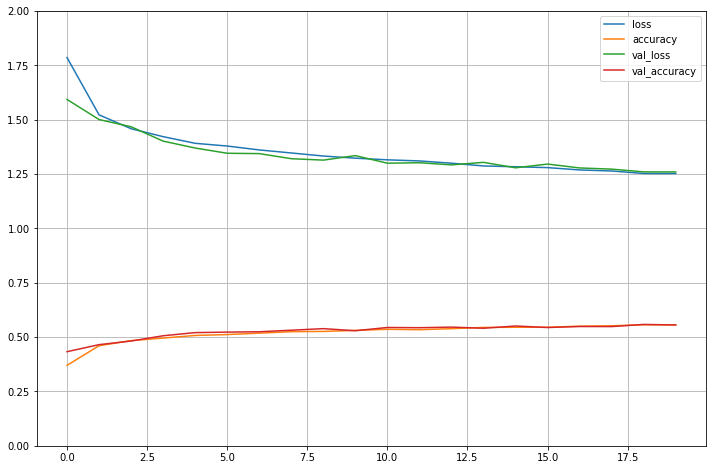

In [50]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
for layer in conv_base.layers:
  layer.trainable = True

In [52]:
start = time.time()
history = model.fit(ds_train,
                    epochs=20,
                    validation_data = ds_val)

print(f"It took {time.time() - start} seconds")

Epoch 1/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2497 - accuracy: 0.5594 - val_loss: 1.3006 - val_accuracy: 0.5446
Epoch 2/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2418 - accuracy: 0.5612 - val_loss: 1.2672 - val_accuracy: 0.5544
Epoch 3/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2364 - accuracy: 0.5637 - val_loss: 1.2440 - val_accuracy: 0.5590
Epoch 4/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2383 - accuracy: 0.5621 - val_loss: 1.2334 - val_accuracy: 0.5662
Epoch 5/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2271 - accuracy: 0.5649 - val_loss: 1.2327 - val_accuracy: 0.5642
Epoch 6/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2260 - accuracy: 0.5659 - val_loss: 1.2521 - val_accuracy: 0.5574
Epoch 7/20
1172/1172 [==============================] - 20s 17ms/step - loss: 1.2221 - accuracy: 0.5654 - val_loss: 1.2476 -

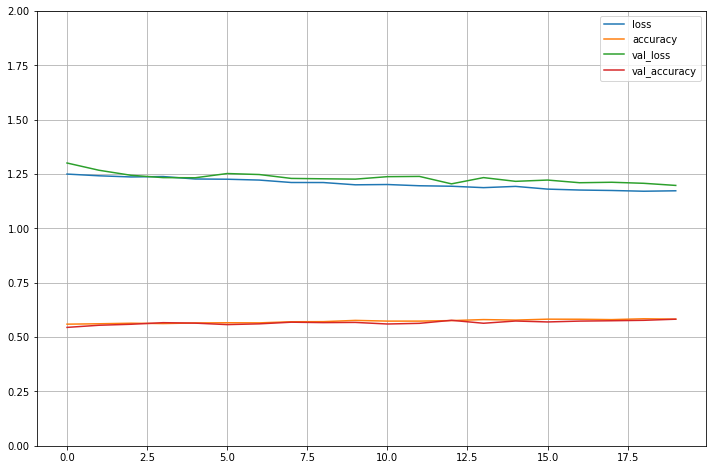

In [53]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

## **Annexe : Connection au drive, import des données, création des dossiers**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Pour ce TP nous utiliserons le dataset d'entraînement fourni par Kaggle pour la compétition **Dogs vs. Cats**.


https://www.kaggle.com/c/dogs-vs-cats/data

In [0]:
%cd /content/drive/My\ Drive
base_path = '/content/drive/My Drive'
!pwd
!ls

/content/drive/My Drive
/content/drive/My Drive
 cats_and_dogs_small  'Colab Notebooks'   config   data_dir


### **Root dir**

In [0]:
!unzip -q train.zip -d data_dir

In [0]:
os.rename(os.path.join(base_path, 'data_dir/train'), os.path.join(base_path, 'data_dir/raw_data'))

In [0]:
%cd /content/drive/My Drive/data_dir
base_dir = '/content/drive/My Drive/data_dir'
raw_data = os.path.join(base_path, 'data_dir/raw_data')
!pwd

/content/drive/My Drive/data_dir
/content/drive/My Drive/data_dir


In [0]:
!ls

raw_data  test	train  validation


### **Train, Test, Validation dir**

#### **Adresse**

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### **mkdir**

In [0]:
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

### **Train, Test, Validation subdirs**

#### **Adresse**

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

In [0]:
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

#### **mkdir**

In [0]:
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)

In [0]:
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)

In [0]:
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

### **Partition des données**

In [0]:
images = [f for f in listdir(raw_data) if isfile(join(raw_data, f))]
images[:5]

In [0]:
len(images)

25000

In [0]:
cats = ['cat.{}.jpg'.format(i) for i in range(4000)]
dogs = ['dog.{}.jpg'.format(i) for i in range(4000)]
print(len(cats), len(dogs))

4000 4000


In [0]:
cats_train, cats_test = train_test_split(cats, test_size=0.25, random_state=RANDOM_SEED)
cats_train, cats_val = train_test_split(cats_train, test_size=0.25, random_state=RANDOM_SEED)

In [0]:
dogs_train, dogs_test = train_test_split(dogs, test_size=0.25, random_state=RANDOM_SEED)
dogs_train, dogs_val = train_test_split(dogs_train, test_size=0.25, random_state=RANDOM_SEED)

In [0]:
def create_ds(new_dir, fnames):
   
    for fname in fnames:
        src = os.path.join(raw_data, fname)
        dst = os.path.join(new_dir, fname)
        shutil.copyfile(src, dst)
    print(f'Finished copying files in {new_dir}')

In [0]:
create_ds(train_cats_dir, cats_train)
create_ds(train_dogs_dir, dogs_train)

create_ds(validation_cats_dir, cats_val)
create_ds(validation_dogs_dir, dogs_val)

create_ds(test_cats_dir, cats_test)
create_ds(test_dogs_dir, dogs_test)

Finished copying files in /content/drive/My Drive/data_dir/train/cats
Finished copying files in /content/drive/My Drive/data_dir/train/dogs
Finished copying files in /content/drive/My Drive/data_dir/validation/cats
Finished copying files in /content/drive/My Drive/data_dir/validation/dogs
Finished copying files in /content/drive/My Drive/data_dir/test/cats
Finished copying files in /content/drive/My Drive/data_dir/test/dogs


### **NUKE : suppression des dossiers**

In [0]:
shutil.rmtree(train_cats_dir)
print("File Removed!")
shutil.rmtree(train_dogs_dir)
print("File Removed!")
shutil.rmtree(validation_cats_dir)
print("File Removed!")
shutil.rmtree(validation_dogs_dir)
print("File Removed!")
shutil.rmtree(test_cats_dir)
print("File Removed!")
shutil.rmtree(test_dogs_dir)
print("File Removed!")

File Removed!
File Removed!
File Removed!
File Removed!
File Removed!
File Removed!


In [0]:
shutil.rmtree(train_dir)
print("File Removed!")
shutil.rmtree(validation_dir)
print("File Removed!")
shutil.rmtree(test_dir)
print("File Removed!")

File Removed!
File Removed!
File Removed!


## **Créer un dataset depuis des images dans un dossier** `tf.data.Dataset.from_tensor_slices`

Cette fois, ci on crée un dataset directement depuis le repertoire `raw_data`, créer des dossiers séparés à chaque fois peut êêtre contraignant, surtout si l'on a beaucoup de données et beaucoup de classes.

In [0]:
cats = [os.path.join(raw_data,'cat.{}.jpg').format(i) for i in range(4000)]
dogs = [os.path.join(raw_data,'dog.{}.jpg').format(i) for i in range(4000)]
data = cats + dogs

data.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(RANDOM_SEED)
random.shuffle(data) # shuffles the ordering of filenames (deterministic given the chosen seed)


data[:5]

['/content/drive/My Drive/data_dir/raw_data/dog.1179.jpg',
 '/content/drive/My Drive/data_dir/raw_data/cat.2910.jpg',
 '/content/drive/My Drive/data_dir/raw_data/dog.1186.jpg',
 '/content/drive/My Drive/data_dir/raw_data/cat.3931.jpg',
 '/content/drive/My Drive/data_dir/raw_data/cat.1029.jpg']

In [0]:
labels = [1 if 'dog' in os.path.basename(file) else 0 for file in data]
labels[:5]

[1, 0, 1, 0, 0]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED)

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES=2

In [0]:
def parse_image(filename,label):
    
    # convert the label to one-hot encoding
    label = tf.one_hot(label, NUM_CLASSES)
    
    #decode image
    image = tf.io.read_file(filename)
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image)
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image, label

In [0]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [0]:
def create_train_dataset(features, labels, batch=32, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
    dataset = dataset.repeat(repet)
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(prefetch)
    return dataset

In [0]:
def create_test_dataset(features, labels, batch=32, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
    dataset = dataset.repeat(repet)
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(prefetch)
    return dataset

In [0]:
ds_train = create_train_dataset(X_train, y_train)
ds_val = create_test_dataset(X_val, y_val)
ds_test = create_test_dataset(X_test, y_test)

In [0]:
vgg_tf= vgg_model(input_size = 224,
                  num_classes= 2)

In [0]:
start = time.time()
vgg_tf.fit(ds_train,
           epochs=5,
           validation_data = ds_val)

print(f"It took {time.time() - start} seconds")

Epoch 1/5
141/141 [==============================] - 39s 276ms/step - loss: 0.4093 - accuracy: 0.8031 - val_loss: 0.3043 - val_accuracy: 0.8747
Epoch 2/5
141/141 [==============================] - 36s 252ms/step - loss: 0.3691 - accuracy: 0.8342 - val_loss: 0.3015 - val_accuracy: 0.8747
Epoch 3/5
141/141 [==============================] - 36s 253ms/step - loss: 0.3502 - accuracy: 0.8469 - val_loss: 0.3286 - val_accuracy: 0.8547
Epoch 4/5
141/141 [==============================] - 35s 250ms/step - loss: 0.3625 - accuracy: 0.8409 - val_loss: 0.3704 - val_accuracy: 0.8273
Epoch 5/5
141/141 [==============================] - 35s 249ms/step - loss: 0.3315 - accuracy: 0.8580 - val_loss: 0.2827 - val_accuracy: 0.8813
It took 182.41791415214539 seconds
